Import Libraries

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
import os


Download NLTK Resources

In [94]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bshanmugam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [95]:

file_path = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")

df[['reviews.text', 'reviews.rating']].dropna()
df[df['reviews.text'].str.strip() != '']
df[df['reviews.title'].str.strip() != '']
df['full_review'] = df['reviews.title'].fillna('') + ' - ' + df['reviews.text'].fillna('')
df.rename(columns={'reviews.text': 'text', 'reviews.rating': 'rating','reviews.doRecommend' : 'doRecommend'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)

# After first columns exploration here are the columns we will drop as they do not provide useful information for future activities
columntodrop = ["id","dateAdded","dateUpdated","keys","manufacturer","manufacturerNumber","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.text","reviews.title","reviews.username"]
df.drop(columns=columntodrop, inplace=True, errors='ignore')
print(f"After removing columns: {df.shape}")

##Remove DUplicates 
print(f"Number of duplicate reviews: {df.duplicated(subset=['text']).sum()}")
df = df.drop_duplicates(subset=['text'])
print(f"Shape after dropping duplicates: {df.shape}")
df.columns

Original shape: (5000, 24)
After removing missing: (5000, 25)
After removing columns: (5000, 11)
Number of duplicate reviews: 615
Shape after dropping duplicates: (4385, 11)


Index(['name', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'text', 'sourceURLs',
       'full_review'],
      dtype='object')

Visualize Ratings Distribution

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_5018/2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


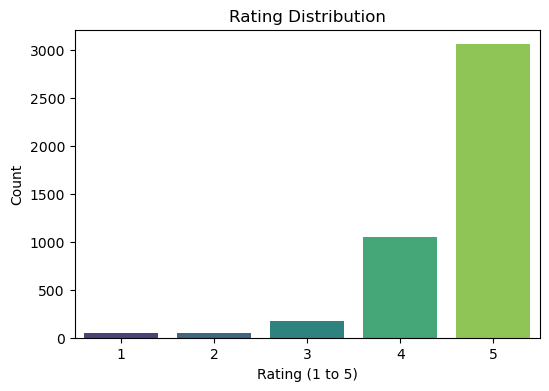

In [96]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_5018/759677541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


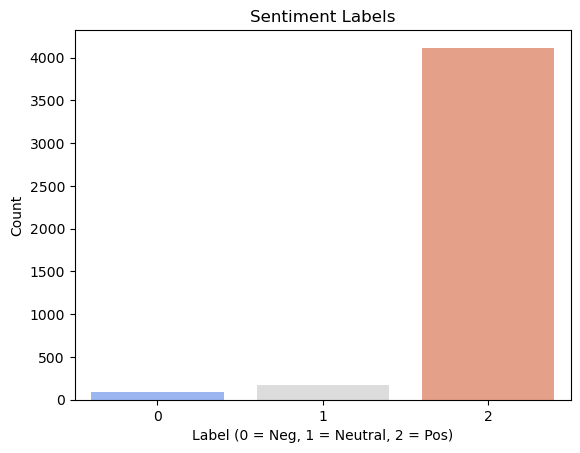

In [97]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()

Clean Text (Simple + Stopwords + Stemming)

In [98]:
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['full_review'].apply(simple_clean_text)
df[['full_review', 'clean_text']].sample(3)


,full_review,clean_text
4506,"So far, so good - Bought it as a Christmas gif...",far good bought christma gift dad someon new g...
623,Amazon Echo Show - I love my echo show. Screen...,amazon echo show love echo show screen clear s...
3194,Even us old people can use it!! - We're in our...,even us old peopl use good time


Top Common Words per Sentiment Class

In [99]:
from collections import Counter
import pandas as pd

def get_top_n_words(text_series, n=15):
    # Ensure we are dealing with strings
    all_words = ' '.join(text_series.dropna().astype(str)).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

# Loop through each sentiment label and show top words
for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'], n=15)
    print(top_words)



🔹 Top words for Negative reviews:
       word  count
0       use     40
1    amazon     34
2    tablet     34
3      work     29
4       buy     28
5       app     25
6    return     23
7    bought     23
8       one     23
9     devic     22
10    kindl     21
11    would     20
12     good     18
13  product     18
14     like     18

🔹 Top words for Neutral reviews:
      word  count
0   tablet     94
1     good     76
2    great     55
3     work     53
4      use     44
5      kid     36
6   amazon     33
7     echo     33
8       ok     31
9     like     29
10     app     29
11    read     27
12     one     27
13    time     27
14   would     25

🔹 Top words for Positive reviews:
       word  count
0     great   2846
1      love   1929
2    tablet   1862
3       use   1464
4      easi    851
5      good    845
6      echo    821
7     kindl    818
8   product    755
9       kid    730
10   amazon    689
11   bought    666
12      one    650
13    alexa    586
14     work    581


Word Cloud per Sentiment Class

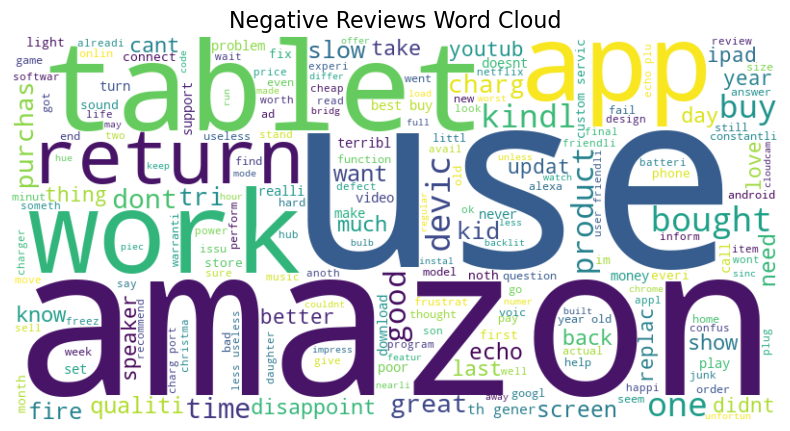

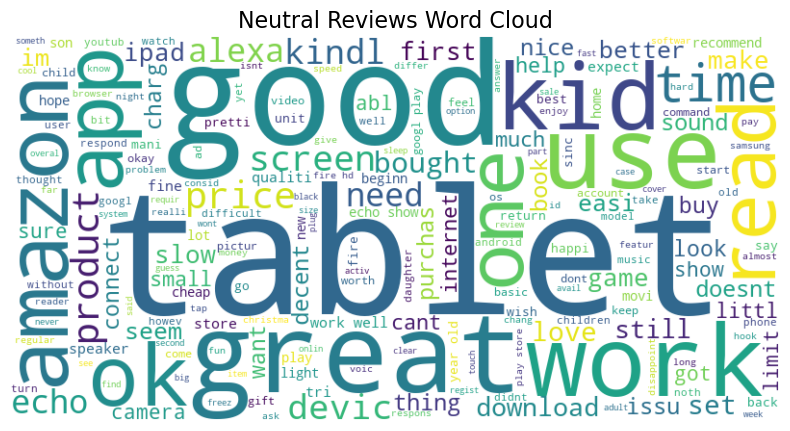

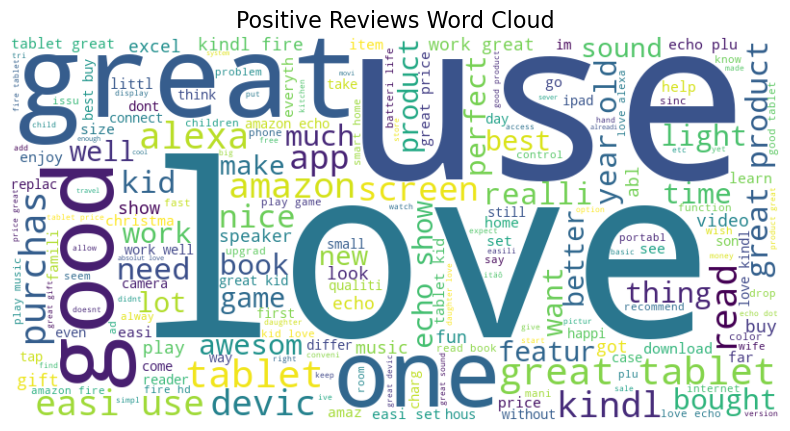

In [100]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [102]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")

✅ Saved: data/cleaned_amazon_reviews_final.csv
